## CREATE AND CUT THE GRAPH

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# !pip install leidenalg==0.7.0

In [ ]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import torch
import numpy
import skimage.color
import torch.nn.functional as F
from MODULES.graph_clustering import *
import time
from typing import List, Tuple

## Helper function

In [ ]:
def do_resolution_sweep(g, res_range, cpm_or_modularity, each_cc_separately):
    video_list, title_list, ncell_list, iou_list, resolution_list, mi_list, sizes_list = [], [], [], [], [], [], []
    for r in res_range:
        partition = g.find_partition_leiden(resolution=r, 
                                            cpm_or_modularity=cpm_or_modularity,
                                            each_cc_separately=each_cc_separately,
                                            min_size=10)
        concordance = partition.concordance_with_partition(other_partition=g.partition_sample_segmask)
        
        mi_list.append(concordance.mutual_information)
        iou_list.append(concordance.iou)
        seg_mask = g.partition_2_mask(partition)
        video_list.append(seg_mask)
        resolution_list.append(r)
        ncell_list.append(len(partition.sizes)-1)
        sizes_list.append(partition.sizes.cpu().numpy())
        
    video = torch.stack(video_list, dim=0).cpu().numpy()

    mydict = {"video": video, 
              "ref_image": g.raw_image[0].cpu().numpy(), 
              "resolution_list": resolution_list, 
              "ncell_list": ncell_list,
              "mi_list": mi_list,
              "iou_list": iou_list,
              "sizes_list": sizes_list}
    return mydict

In [ ]:
def show_video(dictionary: dict,
        figsize: Tuple[int, int] = (8, 4),
        interval: int = 50,
        nbins=10,
        hist_range=(0,200)):
    """
    :param video: an ndarray with shape (n_frames, height, width)
    :param title: an list of lenght (n_frames)    
    """
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)
    ax_video = axs[0,0]
    ax_image = axs[0,1]
    ax_graph = axs[1,0]
    ax_hist = axs[1,1]
    
    # image
    ax_video.axis('off')
    im = ax_video.imshow(skimage.color.label2rgb(dictionary["video"][0, ...], bg_label=0), aspect='equal')
    ax_video.set_title("title")

    # reference image
    ax_image.axis('off')
    _ = ax_image.imshow(dictionary["ref_image"], cmap='gray', aspect='equal')
    
    # graph
    color = 'tab:red'
    _ = ax_graph.plot(dictionary["resolution_list"], dictionary["ncell_list"], '.--', label="n_cell", color=color)
    ax_graph.set_xlabel("resolution")
    ax_graph.set_ylabel('n_cell', color=color)
    ax_graph.tick_params(axis='y', labelcolor=color)
    ax_graph.legend()
    ax_graph.grid()

    ax_graph_2 = ax_graph.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:green'
    _ = ax_graph_2.plot(dictionary["resolution_list"], dictionary["iou_list"], '-', label="iou", color=color)
    ax_graph_2.set_ylabel('iou', color=color)
    ax_graph_2.tick_params(axis='y', labelcolor=color)
    ax_graph_2.legend()
    
    # hist
    _ = ax_hist.hist(dictionary["sizes_list"][0][1:], range=hist_range, density=False, bins=nbins)
    ax_hist.set_title("title")
        
    plt.tight_layout()
    plt.close()
    
    def init():
        im.set_data(dictionary["video"][0, ...])
        ax_video.set_title("title")
        ax_hist.hist(dictionary["sizes_list"][0][1:], range=hist_range, density=False, bins=nbins)
        
    def animate(i):
        title = 'frame={0:3d} res={1:.3f} ncell={2:2d}'.format(i,dictionary["resolution_list"][i],
                                                               dictionary["ncell_list"][i])
        ax_video.imshow(skimage.color.label2rgb(dictionary["video"][i, ...], bg_label=0))
        ax_video.set_title(title)
        ax_hist.clear()
        ax_hist.hist(dictionary["sizes_list"][i][1:], range=hist_range, density=False, bins=nbins)
        ax_hist.set_title("PDF cell size")
        
    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=dictionary["video"].shape[0],
        interval=interval)
    
    return HTML(anim.to_html5_video())

# Import files

In [ ]:
# LARGE
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL_v2.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_LARGE.pt" 
#mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july9_radius5_SMALL_v3.pt" 

mask_file_dot = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_JULY/NEW_tiling_july17_radius10_DOT_PRODUCT.pt"

In [65]:
# DEBUG
tiling_original = torch.load(mask_file_dot, map_location=torch.device('cpu'))

g = GraphSegmentation(tiling_original, 
                      min_fg_prob=0.1, 
                      min_edge_weight=0.1, 
                      normalize_graph_edges=False)
g = GraphSegmentation(tiling_original.reduce_similarity_radius(new_radius = 5), 
                      min_fg_prob=0.1, 
                      min_edge_weight=0.1, 
                      normalize_graph_edges=False)
g = GraphSegmentation(tiling_original.reduce_similarity_radius(new_radius = 2), 
                      min_fg_prob=0.1, 
                      min_edge_weight=0.1, 
                      normalize_graph_edges=False)


g = GraphSegmentation(tiling_original, 
                      min_fg_prob=0.1, 
                      min_edge_weight=0.1, 
                      normalize_graph_edges=True)
g = GraphSegmentation(tiling_original.reduce_similarity_radius(new_radius = 5), 
                      min_fg_prob=0.1, 
                      min_edge_weight=0.1, 
                      normalize_graph_edges=True)
g = GraphSegmentation(tiling_original.reduce_similarity_radius(new_radius = 2), 
                      min_fg_prob=0.1, 
                      min_edge_weight=0.1, 
                      normalize_graph_edges=True)




# Load and plot results without normalizing the graph

In [37]:
tiling_original = torch.load(mask_file_dot, map_location=torch.device('cpu'))

In [38]:
g = GraphSegmentation(tiling_original, min_fg_prob=0.1, min_edge_weight=0.1, normalize_graph_edges=False)

#sweep_CPM_radius_10_NO_norm = do_resolution_sweep(g, 
#                                          res_range=numpy.arange(0.1,10.0,0.5), 
#                                          each_cc_separately=False,
#                                          cpm_or_modularity="cpm")
#

sweep_MOD_radius_10_NO_norm = do_resolution_sweep(g, 
                                          res_range=numpy.arange(0.1,6.0,0.1), 
                                          each_cc_separately=False,
                                          cpm_or_modularity="modularity")

g = GraphSegmentation(tiling_original, min_fg_prob=0.1, min_edge_weight=0.1, normalize_graph_edges=True)

#sweep_CPM_radius_10_YES_norm = do_resolution_sweep(g, 
#                                          res_range=numpy.arange(0.1,10.0,0.5), 
#                                          each_cc_separately=False,
#                                          cpm_or_modularity="cpm")


sweep_MOD_radius_10_YES_norm = do_resolution_sweep(g, 
                                          res_range=numpy.arange(0.1,6.0,0.1), 
                                          each_cc_separately=False,
                                          cpm_or_modularity="modularity")

In [39]:
tiling = tiling_original.reduce_similarity_radius(new_radius = 5)
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.1, normalize_graph_edges=False)

#sweep_CPM_radius_5_NO_norm = do_resolution_sweep(g, 
#                                         res_range=numpy.arange(0.5,10.0,0.5), 
#                                         each_cc_separately=False,
#                                         cpm_or_modularity="cpm")
#

sweep_MOD_radius_5_NO_norm = do_resolution_sweep(g, 
                                         res_range=numpy.arange(0.1,6.0,0.1), 
                                         each_cc_separately=False,
                                         cpm_or_modularity="modularity")


g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.1, normalize_graph_edges=True)

#sweep_CPM_radius_5_YES_norm = do_resolution_sweep(g, 
#                                         res_range=numpy.arange(0.5,10.0,0.5), 
#                                         each_cc_separately=False,
#                                         cpm_or_modularity="cpm")
#
#
sweep_MOD_radius_5_YES_norm = do_resolution_sweep(g, 
                                         res_range=numpy.arange(0.1,6.0,0.1), 
                                         each_cc_separately=False,
                                         cpm_or_modularity="modularity")

In [40]:
tiling = tiling_original.reduce_similarity_radius(new_radius = 2)
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.1, normalize_graph_edges=False)

#sweep_CPM_radius_2_NO_norm = do_resolution_sweep(g, 
#                                         res_range=numpy.arange(0.5,10.0,0.5), 
#                                         each_cc_separately=False,
#                                         cpm_or_modularity="cpm")
#
sweep_MOD_radius_2_NO_norm = do_resolution_sweep(g, 
                                         res_range=numpy.arange(0.1,6.0,0.1), 
                                         each_cc_separately=False,
                                         cpm_or_modularity="modularity")


g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.1, normalize_graph_edges=True)

#sweep_CPM_radius_2_YES_norm = do_resolution_sweep(g, 
#                                         res_range=numpy.arange(0.5,10.0,0.5), 
#                                         each_cc_separately=False,
#                                         cpm_or_modularity="cpm")

sweep_MOD_radius_2_YES_norm = do_resolution_sweep(g, 
                                         res_range=numpy.arange(0.1,6.0,0.1), 
                                         each_cc_separately=False,
                                         cpm_or_modularity="modularity")

# Examine the results

In [49]:
def plot_comparison(which_list,cpm_or_modularity):

    fig, axs = plt.subplots(ncols=2, figsize=(12,6))
    fig.suptitle(which_list+"  "+cpm_or_modularity, fontsize=16)
    
    ax0 = axs[0]
    ax1 = axs[1]
    ax0.set_title("YES_norm")
    ax1.set_title("NO_norm")
    if which_list == "ncell_list":
        ax0.set_ylim(15,25)
        ax1.set_ylim(15,25)

    if cpm_or_modularity == "cpm":
        ax0.plot(sweep_CPM_radius_10_YES_norm["resolution_list"],sweep_CPM_radius_10_YES_norm[which_list], 'x--', label="CPM 10",color="blue")
        ax0.plot(sweep_CPM_radius_5_YES_norm["resolution_list"],sweep_CPM_radius_5_YES_norm[which_list], 'x--', label="CPM 5",color="red")
        ax0.plot(sweep_CPM_radius_2_YES_norm["resolution_list"],sweep_CPM_radius_2_YES_norm[which_list], 'x--', label="CPM 2",color="green")
        
        ax1.plot(sweep_CPM_radius_10_NO_norm["resolution_list"],sweep_CPM_radius_10_NO_norm[which_list], 'x--', label="CPM 10",color="blue")
        ax1.plot(sweep_CPM_radius_5_NO_norm["resolution_list"],sweep_CPM_radius_5_NO_norm[which_list], 'x--', label="CPM 5",color="red")
        ax1.plot(sweep_CPM_radius_2_NO_norm["resolution_list"],sweep_CPM_radius_2_NO_norm[which_list], 'x--', label="CPM 2",color="green")
    else:
        ax0.plot(sweep_MOD_radius_10_YES_norm["resolution_list"],sweep_MOD_radius_10_YES_norm[which_list], 'o-', label="MOD 10",color="blue")
        ax0.plot(sweep_MOD_radius_5_YES_norm["resolution_list"],sweep_MOD_radius_5_YES_norm[which_list], 'o-', label="MOD 5",color="red")
        ax0.plot(sweep_MOD_radius_2_YES_norm["resolution_list"],sweep_MOD_radius_2_YES_norm[which_list], 'o-', label="MOD 2",color="green")
        
        ax1.plot(sweep_MOD_radius_10_NO_norm["resolution_list"],sweep_MOD_radius_10_NO_norm[which_list], 'o-', label="MOD 10",color="blue")
        ax1.plot(sweep_MOD_radius_5_NO_norm["resolution_list"],sweep_MOD_radius_5_NO_norm[which_list], 'o-', label="MOD 5",color="red")
        ax1.plot(sweep_MOD_radius_2_NO_norm["resolution_list"],sweep_MOD_radius_2_NO_norm[which_list], 'o-', label="MOD 2",color="green")
       
    ax0.grid()
    ax0.legend()
    ax0.set_xlabel('resolution parameter')
    
    ax1.grid()
    ax1.legend()
    ax1.set_xlabel('resolution parameter')

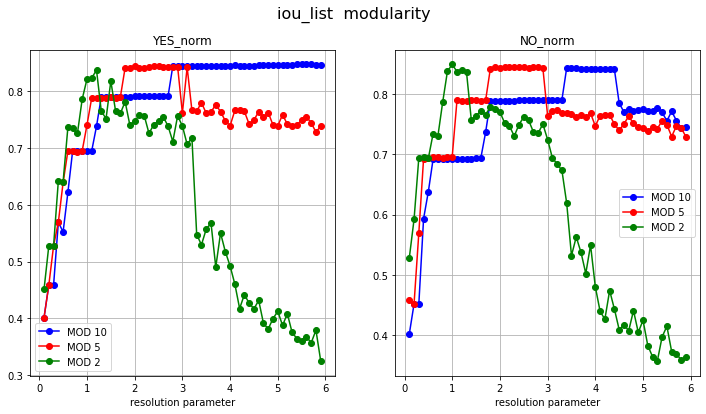

In [50]:
plot_comparison("iou_list","modularity")

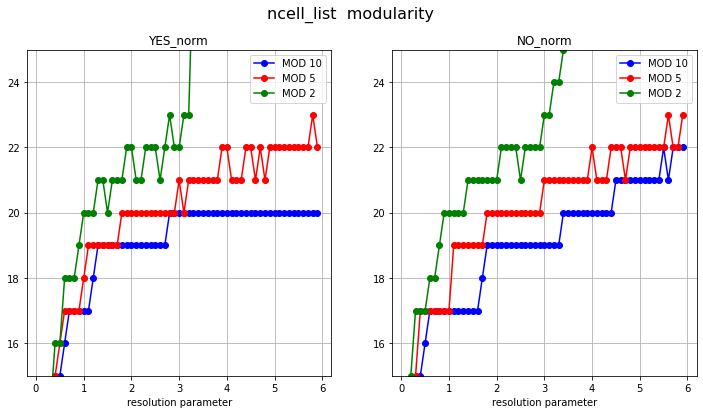

In [51]:
plot_comparison("ncell_list","modularity")

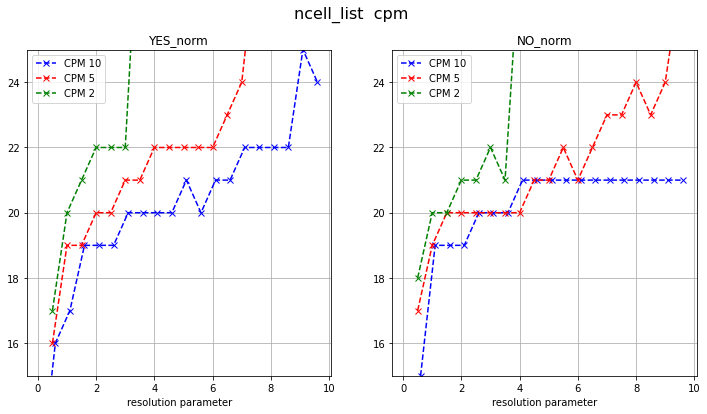

In [52]:
plot_comparison("ncell_list","cpm")

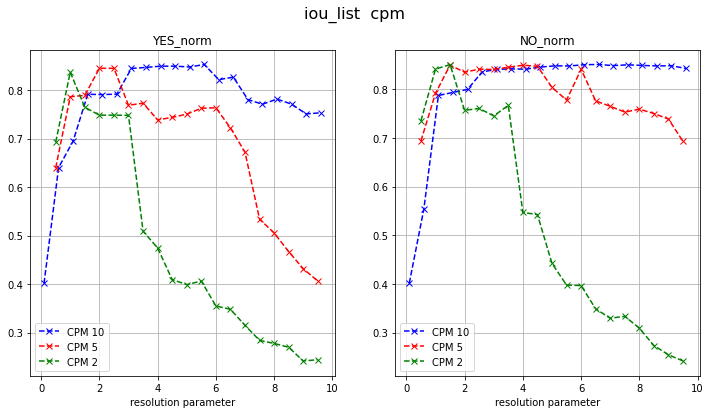

In [53]:
plot_comparison("iou_list","cpm")

# SHOW A VIDEO WITH AND WITHOUT EDGE NORMALIZATION

In [48]:
#show_video(dictionary=sweep_MOD_radius_2_NO_norm, interval=500, nbins=50, hist_range=(0,300))

In [55]:
show_video(dictionary=sweep_MOD_radius_5_NO_norm, interval=500, nbins=50, hist_range=(0,600))

In [56]:
#show_video(dictionary=sweep_MOD_radius_10_NO_norm, interval=500, nbins=50, hist_range=(0,200))

In [ ]:
#show_video(dictionary=sweep_CPM_radius_2, interval=500, nbins=50, hist_range=(0,200))

In [ ]:
#show_video(dictionary=sweep_CPM_radius_5, interval=500, nbins=50, hist_range=(0,200))

In [ ]:
#show_video(dictionary=sweep_CPM_radius_10, interval=500, nbins=50, hist_range=(0,200))

# MANUAL ANALYSIS

In [85]:
tiling_original = torch.load(mask_file_dot, map_location=torch.device('cpu'))
tiling = tiling_original.reduce_similarity_radius(new_radius = 5)
g = GraphSegmentation(tiling, min_fg_prob=0.1, min_edge_weight=0.1)

In [86]:
# graph summary

g.graph.summary()

'IGRAPH U-W- 3037 127239 -- \n+ attr: total_edge_weight (g), total_nodes (g), label (v), weight (e)'

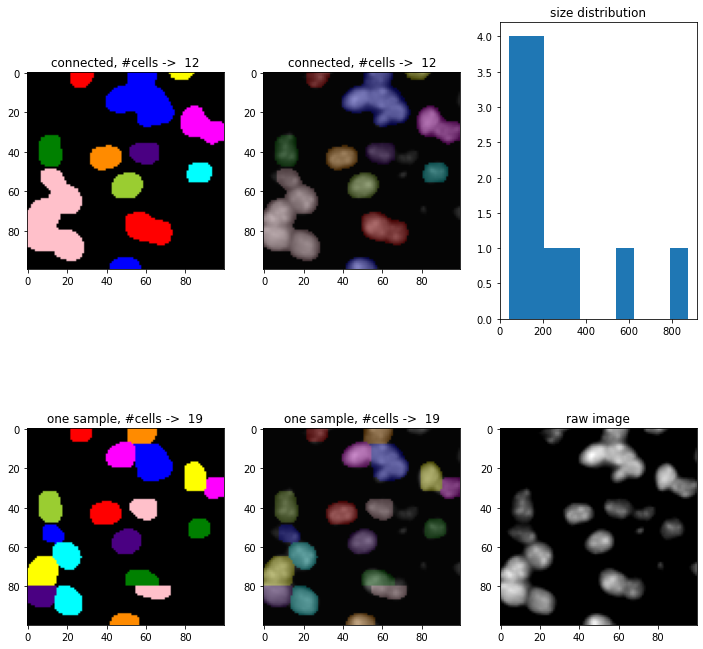

In [87]:
_ = g.plot_partition()

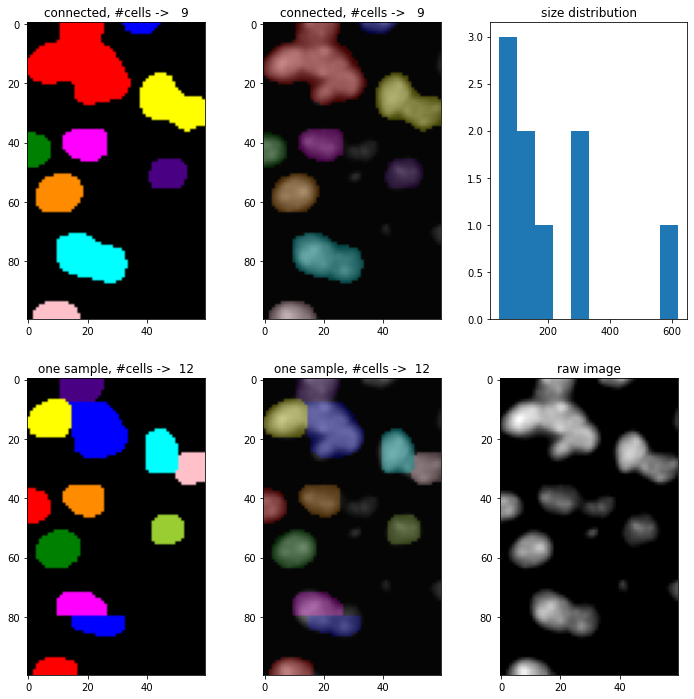

In [88]:
#_ = g.plot_partition(window=(40,0,100,40))
_ = g.plot_partition(window=(0,40,100,1000))

resolution sweep,   1 out of  19
resolution sweep,   2 out of  19
resolution sweep,   3 out of  19
resolution sweep,   4 out of  19
resolution sweep,   5 out of  19
resolution sweep,   6 out of  19
resolution sweep,   7 out of  19
resolution sweep,   8 out of  19
resolution sweep,   9 out of  19
resolution sweep,  10 out of  19
resolution sweep,  11 out of  19
resolution sweep,  12 out of  19
resolution sweep,  13 out of  19
resolution sweep,  14 out of  19
resolution sweep,  15 out of  19
resolution sweep,  16 out of  19
resolution sweep,  17 out of  19
resolution sweep,  18 out of  19
resolution sweep,  19 out of  19
1.5


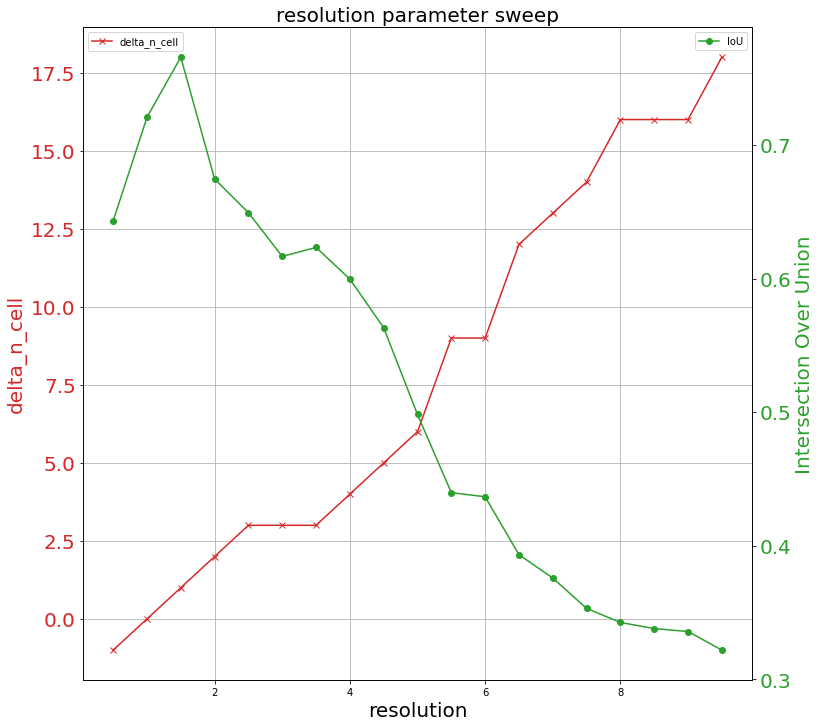

In [94]:
suggestion = g.suggest_resolution_parameter(window=(0,40,100,1000))
print(suggestion.best_resolution)

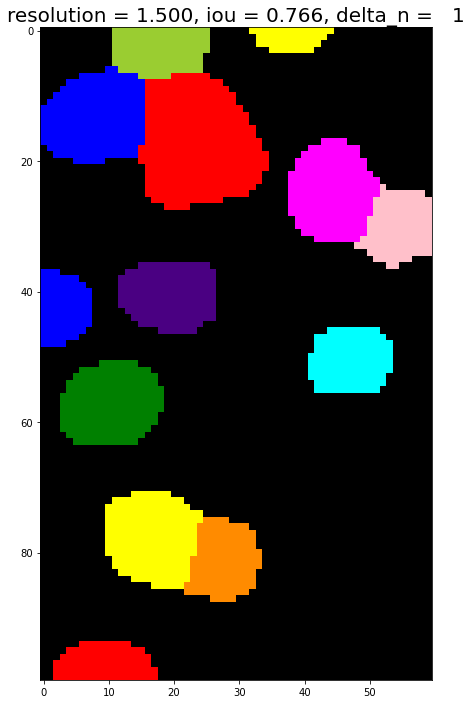

In [97]:
suggestion.show_best(figsize=(12,12))

In [ ]:
time_start = time.time()
partition = g.find_partition_leiden(resolution=1.0, window=(0,40,100,1000))
print("each cc separate ->",time.time()-time_start)
_ = g.plot_partition(partition, window=(0,40,100,1000))

In [ ]:
time_start = time.time()
partition = g.find_partition_leiden(resolution=5.0, 
                                    window=None,#(0,50,100,100),
                                    each_cc_separately=True)
print("each cc separate ->",time.time()-time_start)
_ = g.plot_partition(partition, window=(0,50,100,100))